# Titanic dataset: Least Squares Linear Regression

First step: Imports and data

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS, summarize, poly)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import \
     (cross_validate,
      KFold)
from ISLP.models import sklearn_sm

df = pd.read_csv("../train.csv")
print(df.shape)
print(df.columns)
print(df.dtypes)
for col in df.columns:
    print("Missing rows in {0}:".format(col), df[col].shape[0] - df[col].count())
print(df.describe())


y = df['Survived']

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Missing rows in PassengerId: 0
Missing rows in Survived: 0
Missing rows in Pclass: 0
Missing rows in Name: 0
Missing rows in Sex: 0
Missing rows in Age: 177
Missing rows in SibSp: 0
Missing rows in Parch: 0
Missing rows in Ticket: 0
Missing rows in Fare: 0
Missing rows in Cabin: 687
Missing rows in Embarked: 2
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.4

## Simple Linear Regression

Linear regression on every possible variable.
For that, I have to convert 'Sex' and 'Embarked' to a categorical value. It would also be interesting to convert Cabin, although there are many missing rows. Here, I only convert the first letter of the cabin (always a letter) into its corresponding number (A=1 etc.)

In [3]:
print(df['Cabin'])
print("Missing rows in {0}:".format(col), df['Cabin'].shape[0] - df['Cabin'].count())

print(df['Cabin'].unique())
print(df['Pclass'].unique())

df['CabinLetter'] = df.Cabin.str[:1]
print(df['CabinLetter'].unique())
new_column = []
for line in df.CabinLetter:
    try:
      new_column.append(ord(line) - 64)
    except: new_column.append(line)
df.CabinLetter = new_column
print(df['CabinLetter'].unique())

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object
Missing rows in Embarked: 687
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'


In [4]:
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['SexNr'] = df['Sex'].cat.codes
print(df.dtypes)

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
CabinLetter     float64
SexNr              int8
dtype: object


In [5]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)


for column in ['PassengerId', 'Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'CabinLetter', 'Embarked']:
    X = MS([column]).fit_transform(df)
    model = sm.OLS(y,X, missing='drop') # ordinary least squares model
    results = model.fit()
    print("Modell für {0}:\n".format(column), summarize(results))
    print("Rsquared:", results.rsquared)

    #ax = df.plot.scatter(column, "Survived")
    #abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

Modell für PassengerId:
                  coef   std err       t  P>|t|
intercept    0.388100  0.033000  11.886  0.000
PassengerId -0.000009  0.000063  -0.149  0.881
Rsquared: 2.5066652036165316e-05
Modell für Pclass:
              coef  std err       t  P>|t|
intercept  0.8386    0.045  18.597    0.0
Pclass    -0.1970    0.018 -10.725    0.0
Rsquared: 0.11456941170524171
Modell für Age:
              coef  std err       t  P>|t|
intercept  0.4838    0.042  11.576  0.000
Age       -0.0026    0.001  -2.067  0.039
Rsquared: 0.005963097446925136
Modell für Sex:
              coef  std err       t  P>|t|
intercept  0.7420    0.023  32.171    0.0
Sex[male] -0.5531    0.029 -19.298    0.0
Rsquared: 0.2952307228626888
Modell für SibSp:
              coef  std err       t  P>|t|
intercept  0.3920    0.018  21.726  0.000
SibSp     -0.0156    0.015  -1.054  0.292
Rsquared: 0.001247678927532081
Modell für Parch:
              coef  std err       t  P>|t|
intercept  0.3650    0.018  20.294  0.000


Statistically important are 'Pclass', 'Age', 'Sex', 'Parch', 'Fare' and 'Embarked'

The next step is

## Multiple Linear Regression

First of all, on all of the possible columns at once to see where the results differ

In [6]:
X_2 = MS(['PassengerId', 'Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'CabinLetter', 'Embarked']).fit_transform(df)
model_2 = sm.OLS(y,X_2, missing = 'drop')
results = model_2.fit()
print(summarize(results))
print("Rsquared:", results.rsquared)

               coef  std err      t  P>|t|
intercept    1.1622    0.161  7.217  0.000
PassengerId  0.0003    0.000  2.143  0.033
Pclass      -0.0599    0.069 -0.871  0.385
Age         -0.0063    0.002 -3.068  0.002
Sex[male]   -0.4627    0.059 -7.895  0.000
SibSp        0.0378    0.049  0.773  0.441
Parch       -0.0562    0.044 -1.270  0.206
Fare         0.0001    0.000  0.309  0.758
CabinLetter -0.0083    0.017 -0.473  0.637
Embarked[Q] -0.2577    0.284 -0.906  0.366
Embarked[S] -0.0614    0.065 -0.944  0.347
Rsquared: 0.35534821852700416


The results are a bit different. 'Pclass', 'Age' and 'Sex' are still important. 'Parch', 'Fare' and 'Embarked' have become unimportant. 'SibSp' has become important.

I want to see whether that can be explained with a correlation matrix.

<Axes: >

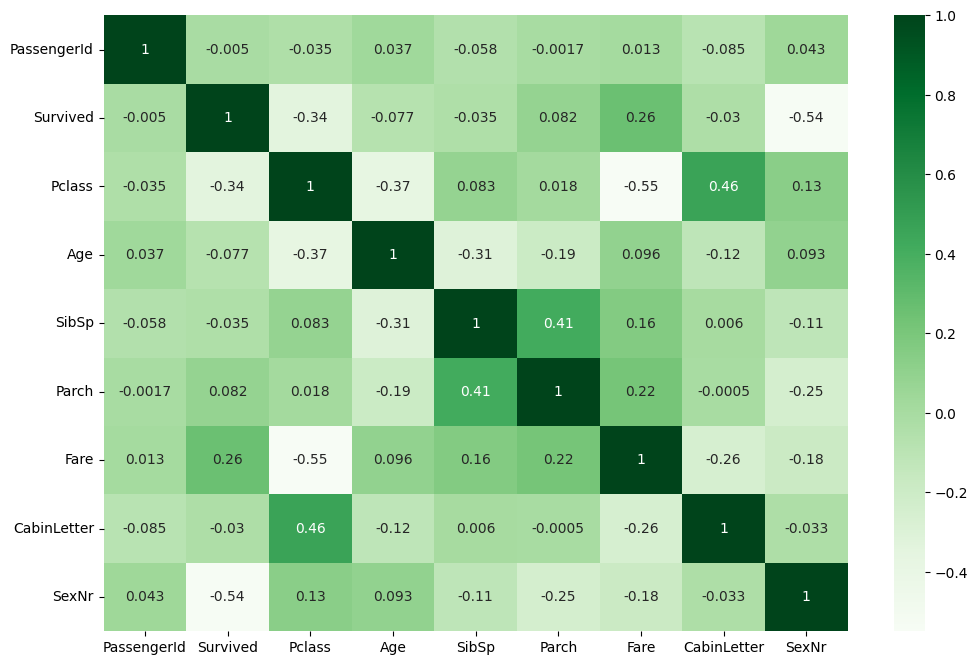

In [7]:
df_2 = df.drop(['Name', 'Ticket', 'Cabin', 'Sex', 'Embarked'], axis=1)
corr = df_2.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens", annot=True)

The important correlations are: 'SibSp' and 'Parch' (0.41), 'Fare' and 'Pclass' (-0.55). So Parch might just have been a surrogate for Parch (although that can't be the full truth, since Parch was not significant in the simple linear regression). It is highly likely though that Fare was just a surrogate for Pclass. We don't know the deal about 'Embarked', since it's a categorical value.

Also interesting: Though not statistically significant, I could show that CabinLetter and Pclass are correlated (0.46). This means the booked room numbers correlate with their Pclass. This MIGHT be interesting - were it not for the fact that Cabin has too many missing values for it to be useful.

First, I want to see whether there is a difference if I completely drop the columns with several missing values (Age and Cabin):

In [8]:
X_2 = MS(['PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']).fit_transform(df)
model_2 = sm.OLS(y,X_2, missing = 'drop')
results = model_2.fit()
print(summarize(results))
print("Rsquared:", results.rsquared)

                coef  std err       t  P>|t|
intercept    1.09740  0.06300  17.371  0.000
PassengerId  0.00001  0.00005   0.194  0.846
Pclass      -0.13790  0.02000  -7.052  0.000
Sex[male]   -0.51920  0.02900 -18.165  0.000
SibSp       -0.03030  0.01300  -2.307  0.021
Parch       -0.00920  0.01800  -0.498  0.619
Fare         0.00030  0.00000   1.039  0.299
Embarked[Q] -0.02430  0.05600  -0.434  0.664
Embarked[S] -0.07340  0.03500  -2.103  0.036
Rsquared: 0.37805984769131595


Does not seem to make a difference. Only that Rsquared is up by 2%.

With all that in mind, I will drop variables from the multiple regression now until they are all significant. I will do this one by one (backward selection).

In [9]:
X_2 = MS(['Pclass', 'Age', 'Sex', 'SibSp']).fit_transform(df)
model_2 = sm.OLS(y,X_2, missing='drop')
results = model_2.fit()
print(summarize(results))
print("Rsquared:", results.rsquared)

             coef  std err       t  P>|t|
intercept  1.3966    0.066  21.287  0.000
Pclass    -0.2053    0.019 -10.937  0.000
Age       -0.0066    0.001  -5.839  0.000
Sex[male] -0.4865    0.031 -15.937  0.000
SibSp     -0.0545    0.016  -3.359  0.001
Rsquared: 0.39971845026903496


Significant are:
- Pclass
- Age
- Sex
- SibSp

Rsquared is at 0.400.

## Linear Regression with interaction

What if I were to include interaction sets? First of all, I will integrate (Age,Sex), (Pclass,Age) and (SibSp,Parch).
Then I'll try out the rest. Although I will leave out cabin because of too many missing values.

In [10]:

X_3 = MS(['Pclass', 'Age', 'SexNr', 'SibSp', 'Parch', 'Fare', 'Embarked']).fit_transform(df) # ('Age','SexNr'),('Pclass','Age'),('SibSp','Parch')
X_3['Age:SexNr'] = df['Age'] * df['SexNr']
X_3['Pclass:Age'] = df['Pclass'] * df['Age']
X_3['SibSp:Parch'] = df['SibSp'] * df['Parch']
#print(X_3)
model_3 = sm.OLS(y,X_3, missing = 'drop')
results = model_3.fit()
print(summarize(results))
print(results.rsquared)

               coef  std err      t  P>|t|
intercept    1.2495    0.129  9.662  0.000
Pclass      -0.1764    0.047 -3.764  0.000
Age         -0.0015    0.003 -0.474  0.636
SexNr       -0.2910    0.067 -4.320  0.000
SibSp       -0.0255    0.028 -0.900  0.369
Parch        0.0068    0.023  0.298  0.766
Fare         0.0001    0.000  0.427  0.670
Embarked[Q] -0.0949    0.082 -1.159  0.247
Embarked[S] -0.0652    0.040 -1.642  0.101
Age:SexNr   -0.0066    0.002 -3.200  0.001
Pclass:Age  -0.0003    0.001 -0.235  0.814
SibSp:Parch -0.0249    0.020 -1.270  0.204
0.4137961039816449


First results: (Age,Sex) is the only significant one of those three, and it also makes Age non-significant. The rest is not significant.
Next, I will include all other interaction terms except for Embarked.

In [11]:
items = ['Pclass', 'Age', 'SexNr', 'SibSp', 'Parch', 'Fare']
for first in range(len(items)):
    for second in range(len(items)):
        if first >= second: continue
        title = items[first] + ':' + items[second]
        X_3[title] = df[items[first]] * df[items[second]]
model_3 = sm.OLS(y,X_3, missing = 'drop')
results = model_3.fit()
print(summarize(results))
print("Rsquared:", results.rsquared)

                  coef   std err      t  P>|t|
intercept     1.458500  0.206000  7.088  0.000
Pclass       -0.263300  0.072000 -3.678  0.000
Age          -0.005400  0.005000 -1.134  0.257
SexNr        -0.713400  0.161000 -4.436  0.000
SibSp         0.175300  0.141000  1.241  0.215
Parch         0.270300  0.098000  2.769  0.006
Fare         -0.003700  0.002000 -1.977  0.048
Embarked[Q]  -0.077500  0.081000 -0.953  0.341
Embarked[S]  -0.059300  0.039000 -1.511  0.131
Age:SexNr    -0.004100  0.002000 -1.723  0.085
Pclass:Age    0.001200  0.002000  0.711  0.478
SibSp:Parch   0.001100  0.025000  0.044  0.965
Pclass:SexNr  0.128400  0.049000  2.616  0.009
Pclass:SibSp -0.097100  0.043000 -2.250  0.025
Pclass:Parch -0.031500  0.032000 -0.989  0.323
Pclass:Fare   0.000700  0.001000  0.535  0.593
Age:SibSp    -0.000038  0.002000 -0.022  0.983
Age:Parch    -0.005700  0.001000 -3.894  0.000
Age:Fare      0.000084  0.000036  2.356  0.019
SexNr:SibSp   0.016700  0.038000  0.441  0.660
SexNr:Parch  

Next, I'll one by one leave out all items that are not significant (backwards selection).

In [12]:
#X_3 = X_3.drop(['SibSp:Parch'], axis=1) # Rsquared: 0.454
#X_3 = X_3.drop(['Age:SibSp'], axis=1) # Rsquared: 0.454
#X_3 = X_3.drop(['SibSp:Fare'], axis=1) # Rsquared: 0.454
#X_3 = X_3.drop(['SexNr:SibSp'], axis=1) # Rsquared: 0.454
#X_3 = X_3.drop(['Pclass:Fare'], axis=1) # Rsquared: 0.454
#X_3 = X_3.drop(['Pclass:Age'], axis=1) # Rsquared: 0.453
#X_3 = X_3.drop(['Embarked[Q]', 'Embarked[S]'], axis=1) # Rsquared: 0.452
#X_3 = X_3.drop(['Pclass:Parch'], axis=1) # Rsquared: 0.451
#X_3 = X_3.drop(['Age'], axis=1) # Rsquared: 0.449
#X_3 = X_3.drop(['SexNr:Parch'], axis=1) # Rsquared: 0.447
#X_3 = X_3.drop(['Parch:Fare'], axis=1) # Rsquared: 0.445
#X_3 = X_3.drop(['SibSp'], axis=1) # Rsquared: 0.442

dropping = ['SibSp:Parch', 'Age:SibSp', 'SibSp:Fare', 'SexNr:SibSp', 'Pclass:Fare',
            'Pclass:Age', 'Embarked[Q]', 'Embarked[S]', 'Pclass:Parch', 'Age',
            'SexNr:Parch', 'Parch:Fare', 'SibSp']
X_3 = X_3.drop(dropping, axis=1)
model_3 = sm.OLS(y,X_3, missing = 'drop')
results = model_3.fit()
print(summarize(results))
print("Rsquared:", results.rsquared)

                  coef   std err       t  P>|t|
intercept     1.358600  0.091000  14.874  0.000
Pclass       -0.266400  0.036000  -7.390  0.000
SexNr        -0.676400  0.136000  -4.968  0.000
Parch         0.207500  0.043000   4.792  0.000
Fare         -0.002800  0.001000  -3.287  0.001
Age:SexNr    -0.006800  0.002000  -4.562  0.000
Pclass:SexNr  0.150100  0.045000   3.357  0.001
Pclass:SibSp -0.033500  0.007000  -5.119  0.000
Age:Parch    -0.006400  0.001000  -5.310  0.000
Age:Fare      0.000065  0.000023   2.856  0.004
SexNr:Fare    0.001600  0.001000   2.384  0.017
Rsquared: 0.4417020798554079


Results of Multiple Linear Regression without interaction terms:
- Significant were Pclass, Sex, Age, SibSp
- Not significant were PassengerId, Parch (although we don't quite know why), Fare (surrogate for Pclass), Embarked, CabinLetter
- Not even taken into account were Name, Ticket, Cabin (the numbers)
- Rsquared was at 0.400

Results of Multiple Linear Regression with interaction terms:
- Significant are: Pclass, Sex, Parch, Fare, Age:SexNr, Pclass:SexNr, Pclass:SibSp, Age:Parch, Age:Fare, SexNr:Fare
- This means that now, Parch and Fare are significant again
- SibSp on the other hand is significant anymore, but it is present in one interaction term
- With each dropping of a non-significant variable, Rsquared got less. In total, in decreased from 0.454 to 0.442, which is its end result for this step

### Linear Regression with Polynomial Functions

Lastly, I want to see whether polynomial functions add value. So for every simple variable and also the interaction terms, I also want to add a quadratic variable. The problem is, I can't find out how to construct these higher-degree variable from the interaction variables. I wanted to use X_3, which has all except the second-degree variables, and simply add those. However, I can't use MS for that, since the columns would have to be in the original dataset (i.e., df). Now, I'll try to use X_3 as the original dataset and create a new X_4 from this using MS (first dropping the intercept, since it gets constructed again anyway).

In [13]:
X_4 = MS([poly('Pclass', degree=2), poly('SexNr', degree=2), poly('Fare', degree=2),
          poly('Age:SexNr', degree=2), poly('Pclass:SexNr', degree=2), poly('Pclass:SibSp', degree=2),
          poly('Age:Parch', degree=2), poly('Age:Fare', degree=2), poly('SexNr:Fare', degree=2),
          poly('Parch', degree=2)]).fit_transform(X_3.drop('intercept', axis=1))

print(X_4.info)
print(X_4.describe())
print(X_3.info)
print(X_3.describe())

<bound method DataFrame.info of      intercept  poly(Pclass, degree=2)[0]  poly(Pclass, degree=2)[1]  \
0          1.0                   0.027718                   0.012084   
1          1.0                  -0.052467                   0.027469   
2          1.0                   0.027718                   0.012084   
3          1.0                  -0.052467                   0.027469   
4          1.0                   0.027718                   0.012084   
..         ...                        ...                        ...   
886        1.0                  -0.012374                  -0.064493   
887        1.0                  -0.052467                   0.027469   
888        1.0                   0.027718                   0.012084   
889        1.0                  -0.052467                   0.027469   
890        1.0                   0.027718                   0.012084   

     poly(SexNr, degree=2)[0]  poly(SexNr, degree=2)[1]  \
0                    0.024714               

This seems to have worked somehow. But now several of the second-degree variables don't have valid numbers. Let's see which rows this affects.

In [14]:
print(X_4.columns)
for col in X_4.columns:
    print("Missing rows in {0}:".format(col), X_4[col].shape[0] - X_4[col].count())

Index(['intercept', 'poly(Pclass, degree=2)[0]', 'poly(Pclass, degree=2)[1]',
       'poly(SexNr, degree=2)[0]', 'poly(SexNr, degree=2)[1]',
       'poly(Fare, degree=2)[0]', 'poly(Fare, degree=2)[1]',
       'poly(Age:SexNr, degree=2)[0]', 'poly(Age:SexNr, degree=2)[1]',
       'poly(Pclass:SexNr, degree=2)[0]', 'poly(Pclass:SexNr, degree=2)[1]',
       'poly(Pclass:SibSp, degree=2)[0]', 'poly(Pclass:SibSp, degree=2)[1]',
       'poly(Age:Parch, degree=2)[0]', 'poly(Age:Parch, degree=2)[1]',
       'poly(Age:Fare, degree=2)[0]', 'poly(Age:Fare, degree=2)[1]',
       'poly(SexNr:Fare, degree=2)[0]', 'poly(SexNr:Fare, degree=2)[1]',
       'poly(Parch, degree=2)[0]', 'poly(Parch, degree=2)[1]'],
      dtype='object')
Missing rows in intercept: 0
Missing rows in poly(Pclass, degree=2)[0]: 0
Missing rows in poly(Pclass, degree=2)[1]: 0
Missing rows in poly(SexNr, degree=2)[0]: 0
Missing rows in poly(SexNr, degree=2)[1]: 0
Missing rows in poly(Fare, degree=2)[0]: 0
Missing rows in poly(Far

All the interaction terms with 'Age' have no valid entries. So we'll just leave those as they are, and keep that in mind. I'll evaluate the results with and without those terms, since I don't know if the different sizing of the variables might be a too strong influence.

In [15]:
X_4 = MS([poly('Pclass', degree=2), poly('SexNr', degree=2), poly('Fare', degree=2),
          'Age:SexNr', poly('Pclass:SexNr', degree=2), poly('Pclass:SibSp', degree=2),
          'Age:Parch', 'Age:Fare', poly('SexNr:Fare', degree=2),
          poly('Parch', degree=2)]).fit_transform(X_3.drop('intercept', axis=1))
X_4_noAge = MS([poly('Pclass', degree=2), poly('SexNr', degree=2), poly('Fare', degree=2),
          poly('Pclass:SexNr', degree=2), poly('Pclass:SibSp', degree=2), poly('SexNr:Fare', degree=2),
          poly('Parch', degree=2)]).fit_transform(X_3.drop('intercept', axis=1))
results = sm.OLS(y,X_4, missing = 'drop').fit()
results_noAge = sm.OLS(y,X_4_noAge, missing = 'drop').fit()
print(summarize(results))
print("Rsquared:", results.rsquared) # Rsquared: 0.463
print(summarize(results_noAge))
print("Rsquared:", results_noAge.rsquared) # Rsquared: 0.412

                                     coef   std err      t  P>|t|
intercept                        0.596000  0.065000  9.161  0.000
poly(Pclass, degree=2)[0]       -6.645200  1.136000 -5.850  0.000
poly(Pclass, degree=2)[1]       -2.026600  0.696000 -2.910  0.004
poly(SexNr, degree=2)[0]         0.631100  0.380000  1.661  0.097
poly(SexNr, degree=2)[1]         2.186100  1.327000  1.647  0.100
poly(Fare, degree=2)[0]         -3.428500  1.310000 -2.618  0.009
poly(Fare, degree=2)[1]          0.407800  0.795000  0.513  0.608
Age:SexNr                       -0.007500  0.001000 -4.991  0.000
poly(Pclass:SexNr, degree=2)[0] -8.861700  4.201000 -2.109  0.035
poly(Pclass:SexNr, degree=2)[1]  8.489500  1.909000  4.448  0.000
poly(Pclass:SibSp, degree=2)[0] -4.322900  0.917000 -4.714  0.000
poly(Pclass:SibSp, degree=2)[1] -1.798800  0.954000 -1.886  0.060
Age:Parch                       -0.006100  0.001000 -4.354  0.000
Age:Fare                         0.000064  0.000023  2.787  0.005
poly(SexNr

The Rsquared for the model without Age is 5% lower, a significant amount. I'll use the model with Age included going forward.

Now, I'll do the same as above and use backwards selection until all the variables are significant.

In [16]:
#X_4 = X_4.drop(['poly(SexNr:Fare, degree=2)[1]'], axis=1) # Rsquared: 0.463
#X_4 = X_4.drop(['poly(Parch, degree=2)[1]'], axis=1) # Rsquared: 0.462
#X_4 = X_4.drop(['poly(SexNr:Fare, degree=2)[0]'], axis=1) # Rsquared: 0.462
#X_4 = X_4.drop(['poly(Fare, degree=2)[1]'], axis=1) # Rsquared: 0.461
#X_4 = X_4.drop(['poly(Pclass:SibSp, degree=2)[1]'], axis=1) # Rsquared: 0.459
results = sm.OLS(y,X_4, missing = 'drop').fit()
print(summarize(results))
print("Rsquared:", results.rsquared)

                                     coef   std err      t  P>|t|
intercept                        0.596000  0.065000  9.161  0.000
poly(Pclass, degree=2)[0]       -6.645200  1.136000 -5.850  0.000
poly(Pclass, degree=2)[1]       -2.026600  0.696000 -2.910  0.004
poly(SexNr, degree=2)[0]         0.631100  0.380000  1.661  0.097
poly(SexNr, degree=2)[1]         2.186100  1.327000  1.647  0.100
poly(Fare, degree=2)[0]         -3.428500  1.310000 -2.618  0.009
poly(Fare, degree=2)[1]          0.407800  0.795000  0.513  0.608
Age:SexNr                       -0.007500  0.001000 -4.991  0.000
poly(Pclass:SexNr, degree=2)[0] -8.861700  4.201000 -2.109  0.035
poly(Pclass:SexNr, degree=2)[1]  8.489500  1.909000  4.448  0.000
poly(Pclass:SibSp, degree=2)[0] -4.322900  0.917000 -4.714  0.000
poly(Pclass:SibSp, degree=2)[1] -1.798800  0.954000 -1.886  0.060
Age:Parch                       -0.006100  0.001000 -4.354  0.000
Age:Fare                         0.000064  0.000023  2.787  0.005
poly(SexNr

Now, the Rsquared is at 0.459 (which is only 1,8% higher that the Regression without higher-degree variables).

Results of Multiple Linear Regression without higher-degree variables:
- Significant are: Pclass, Sex, Parch, Fare, Age:SexNr, Pclass:SexNr, Pclass:SibSp, Age:Parch, Age:Fare, SexNr:Fare
- This means that now, Parch and Fare are significant again
- SibSp on the other hand is significant anymore, but it is present in one interaction term
- Rquared was 0.400

Results of Multiple Linear Regression with higher-degree variables:
- ...
- Now, Rsquared is at 0.459. Not as much of an increase as when introducing the interaction terms, but still.

It might be that I've approached the integration of interaction terms and higher degree wrongly. I have basically tried out every interaction variable and every polynomial function (based on the interaction variables). If I do this process the other way around (first polynomial, then interaction variables), I might get different results. Also, though not in this case, it's dangerous to use this approach in settings with many variables. The probability of finding (false) relationships due to the sheer amount of variables is relatively high.

## 10fold Cross-Validation / Bootstrap

First of all, I'm using 10fold CV on all instances of the least squares models:
- Multiple Linear Regression
- Multiple Linear Regression with interaction terms
- Multiple Linear Regression with interaction terms and higher flexibility

### 10fold CV for Multiple Linear Regression

I have to use SexNr instead of Sex (no categorical values). It also can't handle missing values, so I'll use the mean for all missing values or alternatively drop those rows.

In [17]:
# replacing missing values with the mean
mean = np.mean(df['Age'])
df_missingMean = df.copy()
df_missingMean['Age'] = df_missingMean['Age'].fillna(mean)
# dropping the rows
df_missingDrop = df.dropna(subset=['Age'], inplace=False)

hp_model = sklearn_sm(sm.OLS, MS(['Pclass', 'Age', 'SexNr', 'SibSp']))
X, Y = df_missingDrop, df_missingDrop['Survived']
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=cv)
cv_err = np.mean(cv_results['test_score'])
print(cv_err)




0.1458611427821505


The classification error is in both cases 14.59%.

### 10fold CV for Multiple Linear Regression with Interaction Terms

Again, using both the the missing values substituted by the mean as well as dropped.

In [19]:
X_3_missingMean = X_3.copy()
X_3_missingMean['Age:SexNr'] = X_3_missingMean['Age:SexNr'].fillna(np.mean(X_3_missingMean['Age:SexNr']))
X_3_missingMean['Age:Parch'] = X_3_missingMean['Age:Parch'].fillna(np.mean(X_3_missingMean['Age:Parch']))
X_3_missingMean['Age:Fare'] = X_3_missingMean['Age:Fare'].fillna(np.mean(X_3_missingMean['Age:Fare']))
X_3_missingDrop = X_3.dropna(subset=['Age:SexNr', 'Age:Parch', 'Age:Fare'], inplace=False)
print(X_3_missingDrop.columns)
print(X_3_missingMean.columns)

hp_model = sklearn_sm(sm.OLS, MS(["Pclass", "SexNr", "Parch", "Fare", "Age:SexNr", "Pclass:SexNr", "Pclass:SibSp", "Age:Parch", "Age:Fare", "SexNr:Fare"]))
X, Y = X_3_missingMean, df_missingMean['Survived']
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=cv, error_score='raise')
cv_err = np.mean(cv_results['test_score'])
print(cv_err)

Index(['intercept', 'Pclass', 'SexNr', 'Parch', 'Fare', 'Age:SexNr',
       'Pclass:SexNr', 'Pclass:SibSp', 'Age:Parch', 'Age:Fare', 'SexNr:Fare'],
      dtype='object')
Index(['intercept', 'Pclass', 'SexNr', 'Parch', 'Fare', 'Age:SexNr',
       'Pclass:SexNr', 'Pclass:SibSp', 'Age:Parch', 'Age:Fare', 'SexNr:Fare'],
      dtype='object')
0.14127588282407597


The classification error with dropping the missing values is 13.84%.

The classification error with replacing the missing values with their mean is 14.13%.

### 10fold CV for Multiple Linear Regression with Interaction Terms and higher flexibility

There are no missing terms in the dataframe I used for this, so this is just straightforward.

In [23]:
hp_model = sklearn_sm(sm.OLS, MS(['poly(Pclass, degree=2)[0]', 'poly(Pclass, degree=2)[1]',
       'poly(SexNr, degree=2)[0]', 'poly(SexNr, degree=2)[1]',
       'poly(Fare, degree=2)[0]', 'poly(Fare, degree=2)[1]',
       'poly(Pclass:SexNr, degree=2)[0]', 'poly(Pclass:SexNr, degree=2)[1]',
       'poly(Pclass:SibSp, degree=2)[0]', 'poly(Pclass:SibSp, degree=2)[1]',
       'poly(SexNr:Fare, degree=2)[0]', 'poly(SexNr:Fare, degree=2)[1]',
       'poly(Parch, degree=2)[0]', 'poly(Parch, degree=2)[1]']))
X, Y = X_4_noAge, df['Survived']
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=cv, error_score='raise')
cv_err = np.mean(cv_results['test_score'])
print(cv_err)

0.14482972078084227


Classification Errors:
- 14.59% for Multiple Linear Regression
- 14.13% for Multiple Linear Regression with interaction terms when replacing the missing values with the mean
- 13.84% for Multiple Linear Regression with interaction terms when dropping the missing values
- 14.48% for Multiple Linear Regression with interaction terms and higher flexibility

The differences don't seem to be relevant, only maybe for the 13.84%. But around this much seems to be as far as the Least Squares model can go.